# Regression

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('pnd_data.csv')

In [3]:
data['theoretical return'] = data['theoretical profit(%)'] +1

In [4]:
data.head()

,date,order,channel,subscriber_0901,currency,exchange,duration,volume,price before pump,max price,...,month,weekday,hour,weekday_cos,weekday_sin,hour_cos,hour_sin,month_cos,month_sin,theoretical return
0,2018-06-17 18:15:29,535,CryptoPump,0.0,KRL,1,1,0.04,8.990000e-06,1.050000e-05,...,6,6,18,1.0,-2.449294e-16,0.203456,-0.979084,-1.0,1.224647e-16,1.0000
1,2018-06-17 19:45:02,534,Tornado Signals,927.0,BNBX,1,91,0.12,1.027000e-05,2.300000e-05,...,6,6,19,1.0,-2.449294e-16,0.460065,-0.887885,-1.0,1.224647e-16,1.2112
2,2018-06-18 17:59:05,533,Shark Pump Signals,833.0,NETKO,1,319,0.05,1.152000e-05,1.482000e-05,...,6,0,17,1.0,0.000000e+00,-0.068242,-0.997669,-1.0,1.224647e-16,1.2865
3,2018-06-18 19:45:03,532,Tornado Signals,927.0,RR,1,9,0.16,4.600000e-07,1.800000e-06,...,6,0,19,1.0,0.000000e+00,0.460065,-0.887885,-1.0,1.224647e-16,1.2950
4,2018-06-19 19:45:02,531,Tornado Signals,927.0,WIT,1,5,0.16,1.000000e-07,4.500000e-07,...,6,1,19,0.5,8.660254e-01,0.460065,-0.887885,-1.0,1.224647e-16,2.0455


In [5]:
data.describe()

,order,subscriber_0901,exchange,duration,volume,price before pump,max price,our buy price,our profit(%),theoretical buy price,...,month,weekday,hour,weekday_cos,weekday_sin,hour_cos,hour_sin,month_cos,month_sin,theoretical return
count,535.000000,535.000000,535.000000,535.000000,535.000000,5.350000e+02,5.350000e+02,535.000000,535.000000,5.350000e+02,...,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,5.350000e+02,535.000000
mean,268.000000,15906.416822,0.446729,164.502804,70.590654,3.829451e-04,4.314070e-04,0.000242,0.181480,4.020585e-04,...,5.908411,3.085981,14.005607,0.162617,-0.012950,0.035693,-0.543712,-0.220422,8.596333e-02,1.400478
std,154.585467,26671.153718,0.497619,276.475083,351.399044,3.836848e-03,3.865655e-03,0.003475,0.646062,3.849477e-03,...,2.959310,2.014946,5.901974,0.738650,0.655444,0.527752,0.652609,0.652360,7.212615e-01,0.861851
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-07,1.400000e-07,0.000000,-0.641000,1.500000e-07,...,1.000000,0.000000,0.000000,-1.000000,-0.866025,-0.990686,-0.997669,-1.000000,-1.000000e+00,0.359000
25%,134.500000,433.500000,0.000000,16.000000,0.170000,2.965000e-06,4.575000e-06,0.000000,0.000000,3.335000e-06,...,3.000000,1.000000,12.000000,-0.500000,-0.866025,-0.334880,-0.997669,-0.866025,-5.000000e-01,1.002950
50%,268.000000,2210.000000,0.000000,58.000000,2.600000,1.191000e-05,1.570000e-05,0.000002,0.000000,1.336000e-05,...,6.000000,3.000000,17.000000,0.500000,0.000000,-0.068242,-0.887885,-0.500000,1.224647e-16,1.056500
75%,401.500000,13612.000000,1.000000,185.000000,39.650000,5.929500e-05,7.245000e-05,0.000017,0.075300,6.154500e-05,...,8.000000,5.000000,18.000000,1.000000,0.866025,0.460065,-0.136167,0.500000,8.660254e-01,1.398100
max,535.000000,248813.000000,1.000000,2368.000000,6683.360000,7.956478e-02,7.948000e-02,0.079241,8.142900,7.948000e-02,...,12.000000,6.000000,23.000000,1.000000,0.866025,1.000000,0.997669,1.000000,1.000000e+00,9.589000


## check the normality

In [6]:
data.skew()

order                     0.000000
subscriber_0901           2.610921
exchange                  0.214907
duration                  3.264257
volume                   14.237131
price before pump        17.579951
max price                17.160598
our buy price            22.141832
our profit(%)             7.150407
theoretical buy price    17.375913
theoretical profit(%)     4.528523
success                  -0.093823
ranked                   -1.761095
coin cap                  9.742432
coin volume              21.834328
coin ranking              1.624842
month                     0.269400
weekday                  -0.042180
hour                     -1.215812
weekday_cos              -0.302874
weekday_sin               0.024816
hour_cos                  0.086385
hour_sin                  1.261777
month_cos                 0.450661
month_sin                -0.131443
theoretical return        4.528523
dtype: float64

4.5285232207899675


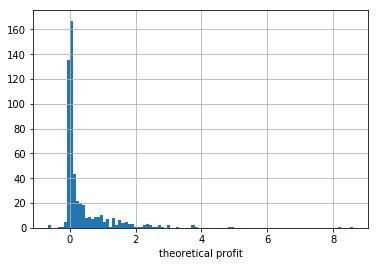

In [7]:
#theoretical profit
profit = data['theoretical profit(%)'].values
plt.hist(profit, bins = 100)
plt.xlabel('theoretical profit')
plt.grid(True)
print(data['theoretical profit(%)'].skew())

4.5285232207899675


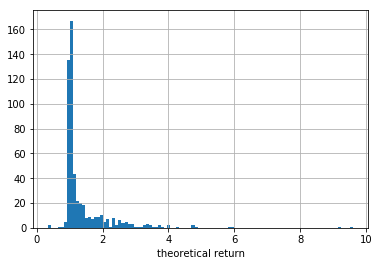

In [8]:
#theoretical return
plt.hist(data['theoretical return'], bins = 100)
plt.xlabel('theoretical return')
plt.grid(True)
print(data['theoretical return'].skew())

1.7981790780293023


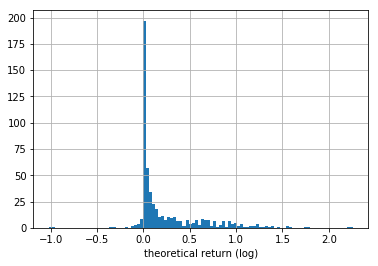

In [9]:
log_after_value = np.log(data['theoretical return'])
print(log_after_value.skew())
plt.hist(log_after_value, bins = 100)
plt.xlabel('theoretical return (log)')
plt.grid(True)

-2.8183441832719067


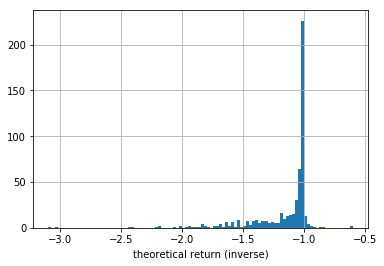

In [10]:
power = 2
inverse_after_value = -(data['theoretical return'])**(1/power)
print(inverse_after_value.skew())
plt.hist(inverse_after_value, bins = 100)
plt.xlabel('theoretical return (inverse)')
plt.grid(True)

## GLM

## theoretical return (theoretical profit +1)

In [11]:
#dependent and indepenedet variables
y = data['theoretical return']
x = data[['month','weekday', 'hour','subscriber_0901','exchange', 'duration', 'volume',
        'ranked']]

In [12]:
#ols model
import statsmodels.api as sm
from scipy import stats
x_t = sm.add_constant(x)
est = sm.OLS(y,x_t)
est2 = est.fit()
print(est2.aic)
est2.summary()

1258.3626546137864


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     theoretical return   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     16.20
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           1.76e-21
Time:                        11:09:09   Log-Likelihood:                -620.18
No. Observations:                 535   AIC:                             1258.
Df Residuals:                     526   BIC:                             1297.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2732      0.171      7.448      0.000       0.937       1.609
month              -0.0214      0.012     -1.799      0.073      -0.045       0.002
weekday            -0.0154      0.017     -0.908      0.364      -0.049       0.018
hour               -0.0111      0.006     -1.848      0.065      -0.023       0.001
subscriber_0901 -1.892e-06   1.42e-06     -1.333      0.183   -4.68e-06    8.97e-07
exchange            0.7480      0.079      9.502      0.000       0.593       0.903
duration        -3.993e-05      0.000     -0.314      0.754      -0.000       0.000
volume          -1.253e-05      0.000     -0.125      0.900      -0.000       0.000
ranked              0.1939      0.095      2.038      0.042       0.007       0.381
==============================================================================
Omnibus:                      543.562   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28994.065
Skew:                           4.487   Prob(JB):                         0.00
Kurtosis:                      37.931   Cond. No.                     1.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#ols model (glm)
est = sm.GLM(y,x_t,family=sm.families.Gaussian())
est2 = est.fit()
print(est2.aic)
est2.summary()

1258.3626546137864


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     theoretical return   No. Observations:                  535
Model:                            GLM   Df Residuals:                      526
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                         0.60503
Method:                          IRLS   Log-Likelihood:                -620.18
Date:                Sun, 08 Mar 2020   Deviance:                       318.25
Time:                        11:09:09   Pearson chi2:                     318.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2732      0.171      7.448      0.000       0.938       1.608
month              -0.0214      0.012     -1.799      0.072      -0.045       0.002
weekday            -0.0154      0.017     -0.908      0.364      -0.049       0.018
hour               -0.0111      0.006     -1.848      0.065      -0.023       0.001
subscriber_0901 -1.892e-06   1.42e-06     -1.333      0.183   -4.67e-06     8.9e-07
exchange            0.7480      0.079      9.502      0.000       0.594       0.902
duration        -3.993e-05      0.000     -0.314      0.753      -0.000       0.000
volume          -1.253e-05      0.000     -0.125      0.900      -0.000       0.000
ranked              0.1939      0.095      2.038      0.042       0.007       0.380
===================================================================================
"""

In [14]:
#ols model + log 
import statsmodels.api as sm
from scipy import stats
x_t = sm.add_constant(x)
est = sm.GLM(y,x_t,family=sm.families.Gaussian(link=sm.families.links.log))
est2 = est.fit()
print(est2.aic)
est2.summary()

1249.5999096436149


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     theoretical return   No. Observations:                  535
Model:                            GLM   Df Residuals:                      526
Model Family:                Gaussian   Df Model:                            8
Link Function:                    log   Scale:                         0.59512
Method:                          IRLS   Log-Likelihood:                -615.80
Date:                Sun, 08 Mar 2020   Deviance:                       313.03
Time:                        11:09:09   Pearson chi2:                     313.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3172      0.130      2.443      0.015       0.063       0.572
month              -0.0216      0.009     -2.411      0.016      -0.039      -0.004
weekday            -0.0114      0.011     -0.996      0.319      -0.034       0.011
hour               -0.0124      0.004     -2.982      0.003      -0.021      -0.004
subscriber_0901 -2.063e-06   1.35e-06     -1.527      0.127   -4.71e-06    5.84e-07
exchange            0.5427      0.059      9.182      0.000       0.427       0.659
duration        -3.038e-05      0.000     -0.283      0.777      -0.000       0.000
volume          -6.138e-06   9.02e-05     -0.068      0.946      -0.000       0.000
ranked              0.1295      0.065      1.998      0.046       0.002       0.257
===================================================================================
"""

## gamma

In [15]:
#gamma model, inverse
x_t = sm.add_constant(x)
est = sm.GLM(y,x_t,family=sm.families.Gamma())
est2 = est.fit()
print(est2.aic)
est2.summary()

719.5047714038905


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     theoretical return   No. Observations:                  535
Model:                            GLM   Df Residuals:                      526
Model Family:                   Gamma   Df Model:                            8
Link Function:          inverse_power   Scale:                         0.17960
Method:                          IRLS   Log-Likelihood:                -350.75
Date:                Sun, 08 Mar 2020   Deviance:                       65.681
Time:                        11:09:09   Pearson chi2:                     94.5
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7890      0.071     11.093      0.000       0.650       0.928
month               0.0118      0.005      2.440      0.015       0.002       0.021
weekday             0.0063      0.006      1.005      0.315      -0.006       0.019
hour                0.0059      0.002      2.581      0.010       0.001       0.010
subscriber_0901  1.265e-06   7.15e-07      1.768      0.077   -1.37e-07    2.67e-06
exchange           -0.3692      0.032    -11.430      0.000      -0.432      -0.306
duration         3.348e-05   5.86e-05      0.571      0.568   -8.14e-05       0.000
volume            1.76e-06   4.96e-05      0.036      0.972   -9.54e-05    9.89e-05
ranked             -0.0665      0.035     -1.889      0.059      -0.135       0.002
===================================================================================
"""

In [16]:
#gamma model, log
import statsmodels.api as sm
from scipy import stats
x_t = sm.add_constant(x)
est = sm.GLM(y,x_t,family=sm.families.Gamma(link=sm.families.links.log))
est2 = est.fit()
print(est2.aic)
est2.summary()

735.4181414602049


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     theoretical return   No. Observations:                  535
Model:                            GLM   Df Residuals:                      526
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.18715
Method:                          IRLS   Log-Likelihood:                -358.71
Date:                Sun, 08 Mar 2020   Deviance:                       67.171
Time:                        11:09:09   Pearson chi2:                     98.4
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1978      0.095      2.080      0.038       0.011       0.384
month              -0.0120      0.007     -1.816      0.069      -0.025       0.001
weekday            -0.0094      0.009     -0.995      0.320      -0.028       0.009
hour               -0.0052      0.003     -1.567      0.117      -0.012       0.001
subscriber_0901 -1.287e-06    7.9e-07     -1.630      0.103   -2.83e-06     2.6e-07
exchange            0.5058      0.044     11.552      0.000       0.420       0.592
duration        -4.534e-05   7.07e-05     -0.641      0.521      -0.000    9.32e-05
volume          -3.591e-06   5.57e-05     -0.065      0.949      -0.000       0.000
ranked              0.0957      0.053      1.807      0.071      -0.008       0.199
===================================================================================
"""